In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, tree_structure
import jax_dataclasses as jdc
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM_Physical,PMSM
import matplotlib.pyplot as plt

In [2]:
random_seed = np.random.randint(0, 2**31)
random_key = jax.random.PRNGKey(seed=random_seed)

In [12]:
new_motor = PMSM_Physical(
    control_state="torque",
    deadtime=0,
    batch_size=2,
    saturated=True,
    params = {
                "p": 3,
                "r_s": 15e-3,
                "l_d": 0.37e-3,
                "l_q": 1.2e-3,
                "psi_p": 65.6e-3,
                "u_dc": 400,
                "i_n": 250,
                "max_omega_el": 3000 / 60 * 2 * jnp.pi,
            })
new_motor_env = PMSM(
    new_motor,
    gamma=0.85,
    batch_size=2,
    static_params = {
                "p_omega": 0.00005,
                "p_reference": 0.0002,
                "p_reset": 1.0,
                "i_lim_multiplier": 1.2,
                "constant_omega": True,
                "omega_ramp_min": 20000,
                "omega_ramp_max": 25000,
            })

In [10]:
obs, motor_env_state = new_motor_env.reset(random_key)
next_state=motor_env_state
i_dqs=[]
for _ in range(100):
    act1=[0.03,0.03]
    act2=[0.03,0.03]
    obs_next,next_state=new_motor_env.vmap_step(next_state,jnp.array([act1,act2]))
    i_dqs.append(obs_next[0,0:2])

Text(0, 0.5, 'i_q')

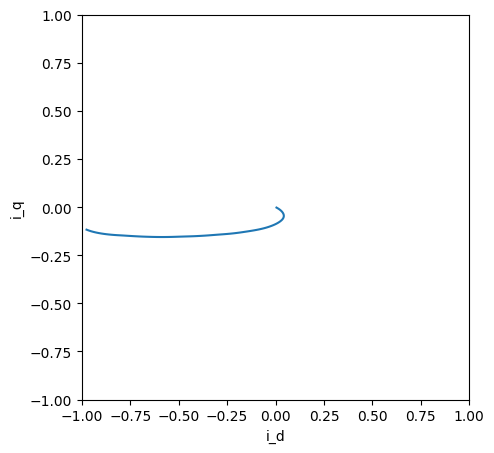

In [11]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1]) #,label="currents"
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")
#ax.legend()

In [13]:
next_state.physical_state.omega

Array([inf, inf], dtype=float32)

### PMSM with GymWrapper

In [9]:
from exciting_environments import GymWrapper

In [10]:
new_motor = PMSM_Physical(control_state="currents", deadtime=0,batch_size=2,saturated=True)
new_motor_env = PMSM(new_motor, gamma=0.85,batch_size=2)
gym_pmsm= GymWrapper(env=new_motor_env)

In [11]:
gym_pmsm.reset(random_key)
i_dqs2=[]
for _ in range(100):
    act1=[-0.03,-0.03]
    act2=[0.03,0.03]
    obs_next,_,_,_=gym_pmsm.step(jnp.array([act1,act2]))
    i_dqs2.append(obs_next[0,0:2])

Text(0, 0.5, 'i_q')

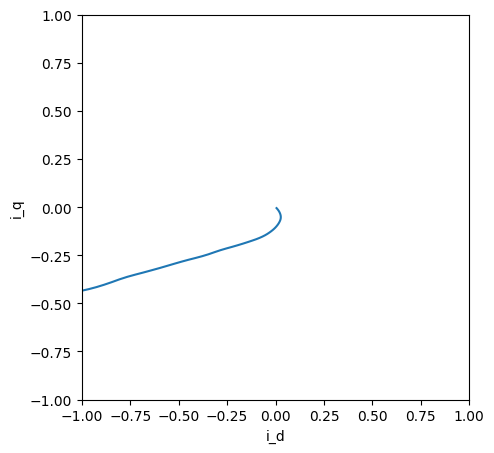

In [12]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1]) #,label="currents"
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")
#ax.legend()